In [6]:
import numpy as np
# matplotlib.use('Agg')
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
from PIL import Image
import requests
from pycocotools.coco import COCO
import os
import random
from collections import defaultdict, OrderedDict
import json
from tqdm import tqdm
import sys
from IPython.display import display

In [3]:
coco_annotation_file_path = "/media/ian/WD/datasets/retail_product_checkout/instances_train2019.json"
COCO_TRAIN = COCO(annotation_file=coco_annotation_file_path)
with open(coco_annotation_file_path) as fid:
    train_json_data = json.load(fid)

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


In [4]:
coco_annotation_file_path = "/media/ian/WD/datasets/retail_product_checkout/instances_val2019.json"
COCO_VAL = COCO(annotation_file=coco_annotation_file_path)

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [4]:
compare_catIds = [i for i in range(1, 201)]
cats = COCO_VAL.loadCats(compare_catIds)
cat_names = [cat["name"] for cat in cats]
print("Categories Names:")
print(cat_names)

Categories Names:
['1_puffed_food', '2_puffed_food', '3_puffed_food', '4_puffed_food', '5_puffed_food', '6_puffed_food', '7_puffed_food', '8_puffed_food', '9_puffed_food', '10_puffed_food', '11_puffed_food', '12_puffed_food', '13_dried_fruit', '14_dried_fruit', '15_dried_fruit', '16_dried_fruit', '17_dried_fruit', '18_dried_fruit', '19_dried_fruit', '20_dried_fruit', '21_dried_fruit', '22_dried_food', '23_dried_food', '24_dried_food', '25_dried_food', '26_dried_food', '27_dried_food', '28_dried_food', '29_dried_food', '30_dried_food', '31_instant_drink', '32_instant_drink', '33_instant_drink', '34_instant_drink', '35_instant_drink', '36_instant_drink', '37_instant_drink', '38_instant_drink', '39_instant_drink', '40_instant_drink', '41_instant_drink', '42_instant_noodles', '43_instant_noodles', '44_instant_noodles', '45_instant_noodles', '46_instant_noodles', '47_instant_noodles', '48_instant_noodles', '49_instant_noodles', '50_instant_noodles', '51_instant_noodles', '52_instant_noodles

In [8]:
val_size_dict = {}  # val2019 data,
for cat in compare_catIds:
    # ======== synthesized =========
    # annIds = coco_ann_check.getAnnIds(catIds=[cat])
    # anns = coco_ann_check.loadAnns(annIds)
    # box_sizes = []
    # for ann in anns:
    #     box_sizes.append(ann['bbox'][2]*ann['bbox'][3])
    # box_sizes = np.array(box_sizes)
    # syn_avg = np.average(box_sizes)
    # ======== val2019 =========
    annIds = COCO_VAL.getAnnIds(catIds=[cat])
    anns = COCO_VAL.loadAnns(annIds)
    box_sizes = []
    for ann in anns:
        box_sizes.append(ann['bbox'][2] * ann['bbox'][3])
    box_sizes = np.array(box_sizes)
    val_avg = np.max(box_sizes)
    val_size_dict[cat] = val_avg
print(val_size_dict)
# print("cat ID: {}, val_avg/syn_avg:{}".format(cat, (val_avg/(syn_avg)+1)))

{1: 390141.58410000004, 2: 377872.98120000004, 3: 447995.01599999995, 4: 451012.4282999999, 5: 589597.4545, 6: 478829.65680000006, 7: 475871.9203, 8: 464664.303, 9: 471721.7124000001, 10: 498180.49919999996, 11: 502138.51999999996, 12: 383356.38249999995, 13: 423883.83030000003, 14: 471356.37179999996, 15: 533604.6656, 16: 478491.57509999996, 17: 379293.9696, 18: 631236.7152000001, 19: 399651.6544, 20: 325476.85099999997, 21: 314751.1178, 22: 905164.708, 23: 629810.4639999999, 24: 902427.6855, 25: 1075853.3324, 26: 864320.8168, 27: 902002.132, 28: 608973.0304, 29: 349967.1848, 30: 339053.68, 31: 166392.35460000002, 32: 160449.9321, 33: 136978.1644, 34: 141352.9755, 35: 124053.174, 36: 164727.36719999998, 37: 670282.2327, 38: 157211.0115, 39: 267382.60799999995, 40: 144856.2264, 41: 138106.2732, 42: 325812.8946, 43: 330557.97, 44: 330566.03839999996, 45: 163398.0987, 46: 166972.9773, 47: 209099.19749999998, 48: 210977.80000000002, 49: 186605.8901, 50: 279170.8076, 51: 324417.249, 52: 32

In [9]:
train_images = {}
for x in train_json_data['images']:
    train_images[x['id']] = x

train_annotations = {}
for x in train_json_data['annotations']:
    train_annotations[train_images[x['image_id']]['file_name']] = x

object_category_paths = defaultdict(list)
for img_id, info in COCO_TRAIN.imgs.items():
    name = info['file_name']
    category = train_annotations[name]['category_id']
    object_category_paths[category].append(name)
object_category_paths = dict(object_category_paths)

train_size_dict = {}
for category, paths in tqdm(object_category_paths.items()):
    areas = []
    for object_path in paths:
        x, y, w, h = train_annotations[object_path]['bbox']
        area = w * h
        # mask_path = os.path.join('./', 'extracted_masks_tracer5_morph10', 'masks',
        #                          '{}.png'.format(name.split('.')[0]))
        # mask = Image.open(mask_path).convert('L')
        # mask.crop((int(x),int(y),int(x+w),int(y+h)))
        # area = np.array(mask, dtype=bool).sum()

        areas.append(area)  # instance area
    areas = np.array(areas)
    max_area = areas.max()
    train_size_dict[category] = max_area


100%|██████████| 200/200 [00:00<00:00, 6343.76it/s]


In [17]:
COCO_TRAIN.loadCats([1])[0]

{'supercategory': 'puffed_food', 'id': 1, 'name': '1_puffed_food'}

In [18]:
train_val_ratio = OrderedDict()
for i in range(1, 201):
    train_val_ratio[i] = round(val_size_dict[i] / train_size_dict[i], 2)
    print("id:{}, cat:{}, ratio:{}".format(i, COCO_TRAIN.loadCats([i])[0]['supercategory'], train_val_ratio[i]))
with open('train_val_ratio.json', 'w') as fid:
    json.dump(train_val_ratio, fid)

id:1, cat:puffed_food, ratio:0.39
id:2, cat:puffed_food, ratio:0.48
id:3, cat:puffed_food, ratio:0.45
id:4, cat:puffed_food, ratio:0.41
id:5, cat:puffed_food, ratio:0.45
id:6, cat:puffed_food, ratio:0.41
id:7, cat:puffed_food, ratio:0.46
id:8, cat:puffed_food, ratio:0.43
id:9, cat:puffed_food, ratio:0.45
id:10, cat:puffed_food, ratio:0.41
id:11, cat:puffed_food, ratio:0.42
id:12, cat:puffed_food, ratio:0.44
id:13, cat:dried_fruit, ratio:0.42
id:14, cat:dried_fruit, ratio:0.38
id:15, cat:dried_fruit, ratio:0.41
id:16, cat:dried_fruit, ratio:0.44
id:17, cat:dried_fruit, ratio:0.43
id:18, cat:dried_fruit, ratio:0.46
id:19, cat:dried_fruit, ratio:0.45
id:20, cat:dried_fruit, ratio:0.45
id:21, cat:dried_fruit, ratio:0.43
id:22, cat:dried_food, ratio:0.42
id:23, cat:dried_food, ratio:0.38
id:24, cat:dried_food, ratio:0.4
id:25, cat:dried_food, ratio:0.41
id:26, cat:dried_food, ratio:0.42
id:27, cat:dried_food, ratio:0.4
id:28, cat:dried_food, ratio:0.42
id:29, cat:dried_food, ratio:0.44
id:3

In [31]:
# annIds = coco_ann_val.getAnnIds(catIds=compare_catIds)
# anns = coco_ann_val.loadAnns(annIds)
# box_sizes = []
# for ann in anns:
#     box_sizes.append(ann['bbox'][2]*ann['bbox'][3])
# box_sizes = np.array(box_sizes)
# val_avg = np.average(box_sizes)
# print(val_avg/syn_avg)

2.0217493119472993


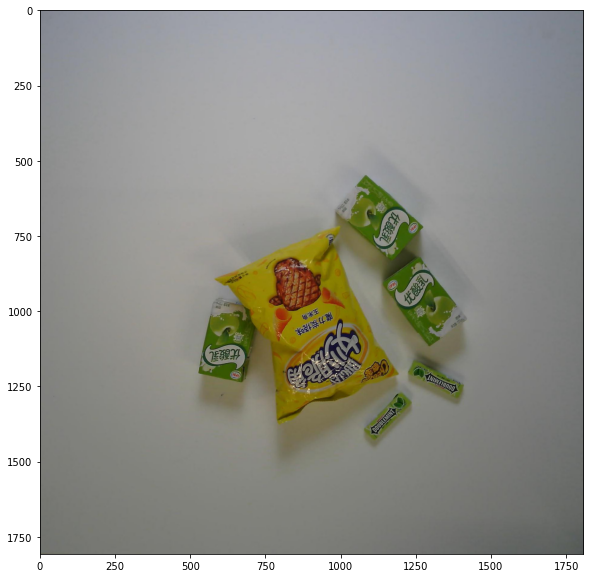

In [8]:
img_info = COCO_VAL.loadImgs(COCO_VAL.getImgIds(catIds=[141])[10])[0]
im = Image.open(os.path.join('/media/ian/WD/datasets/retail_product_checkout/val2019', img_info['file_name']))
plt.imshow(im)

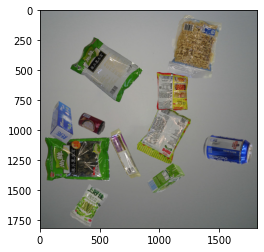

In [5]:
img_info = coco_ann_check.loadImgs(coco_ann_check.getImgIds(catIds=[1])[50])[0]
im = Image.open(os.path.join('/media/ian/WD/datasets/rpc_list/synthesize_3000_test', img_info['file_name']))
plt.imshow(im)